In [ ]:
# https://docs.python.org/3/library/sqlite3.html

import sqlite3
from contextlib import closing


connection = sqlite3.connect('dennis.db')


with closing(connection) as conn:
  with closing(connection.cursor()) as cursor:
    # Enable foreign key constraints
    conn.execute('PRAGMA foreign_keys = ON')

    # Create `commands` table
    cursor.execute('''CREATE TABLE commands
                  ( name TEXT NOT NULL PRIMARY KEY,
                    description TEXT
                  )''')

    # Create `flags` table
    cursor.execute('''CREATE TABLE flags
                  ( uuid INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,
                    long TEXT,
                    short TEXT,
                    description TEXT,
                    type TEXT,
                    required BOOLEAN,
                    command_uuid INTEGER,
                    FOREIGN KEY(command_uuid) REFERENCES commands(uuid)
                  )''')

In [ ]:
# Get a list of commands

import os


def run_command(command):
  output = os.popen(command)
  return output.read()


cmds = ["/bin/bash -c 'compgen -bck'", "apropos -s 1 ''"]
outputs = [run_command(cmd) for cmd in cmds]

commands = []

for output in outputs:
  lines = output.split('\n')
  for line in lines:
    if line:
      parts = line.split(' ')
      if len(parts) == 1:
        command_name = parts[0]
      else:
        command_name = parts[1]
      commands.append(command_name)


# Dedup Commands
commands = list(set(commands))
# print(commands)


In [ ]:
import json
import sqlite3

from pathlib import Path
from contextlib import closing

class ManPageParser:
  def __init__(self, manpage):
    self.text = manpage
    self.description = self.extract('description')
    if self.description:
      self.description = f"{self.get_brief()}\n{self.description}"

  def extract(self, section):
    manpage = self.text
    stop = 0
    if section.upper() in manpage:
      lines = manpage.split(f"{section.upper()}\n")[1].split("\n")
      for index, line in enumerate(lines):
        if not line.startswith(" ") and len(line) > 0: break
        stop = index
      return "\n".join([line.strip() for line in lines[:stop]])
    return False
  
  def get_brief(self):
    brief = self.extract('name')
    if brief:
      brief = brief.split(' - ')
      if len(brief) > 1:
        return brief[1]
    return ''


connection = sqlite3.connect('dennis.db')
manpages   = [Path(f) for f in Path("./data/manpages/").iterdir() if f.is_file()]
data       = []


for manpage in manpages:
  page = manpage.read_text()
  print(manpage.stem)
  result = ManPageParser(page)
  if result.description:
    data.append({
      'command': manpage.stem,
      'description': result.description
    })




# with closing(connection) as conn:
#   with closing(connection.cursor()) as cursor:
#     for manpage in manpages:
#       page = extract_description(manpage.read_text())
#       if page:
#         command = manpage.stem
#         data.append({"command":command, "description":page})
#         # page = page.replace("'", "''")
#         # cursor.execute("INSERT INTO commands (name, description) VALUES (?, ?)", (manpage.stem, page))
#         # connection.commit()


# print(json.dumps(data, indent=2))

Path("dennis.json").write_text(json.dumps(data, indent=2))

usb_modeswitch


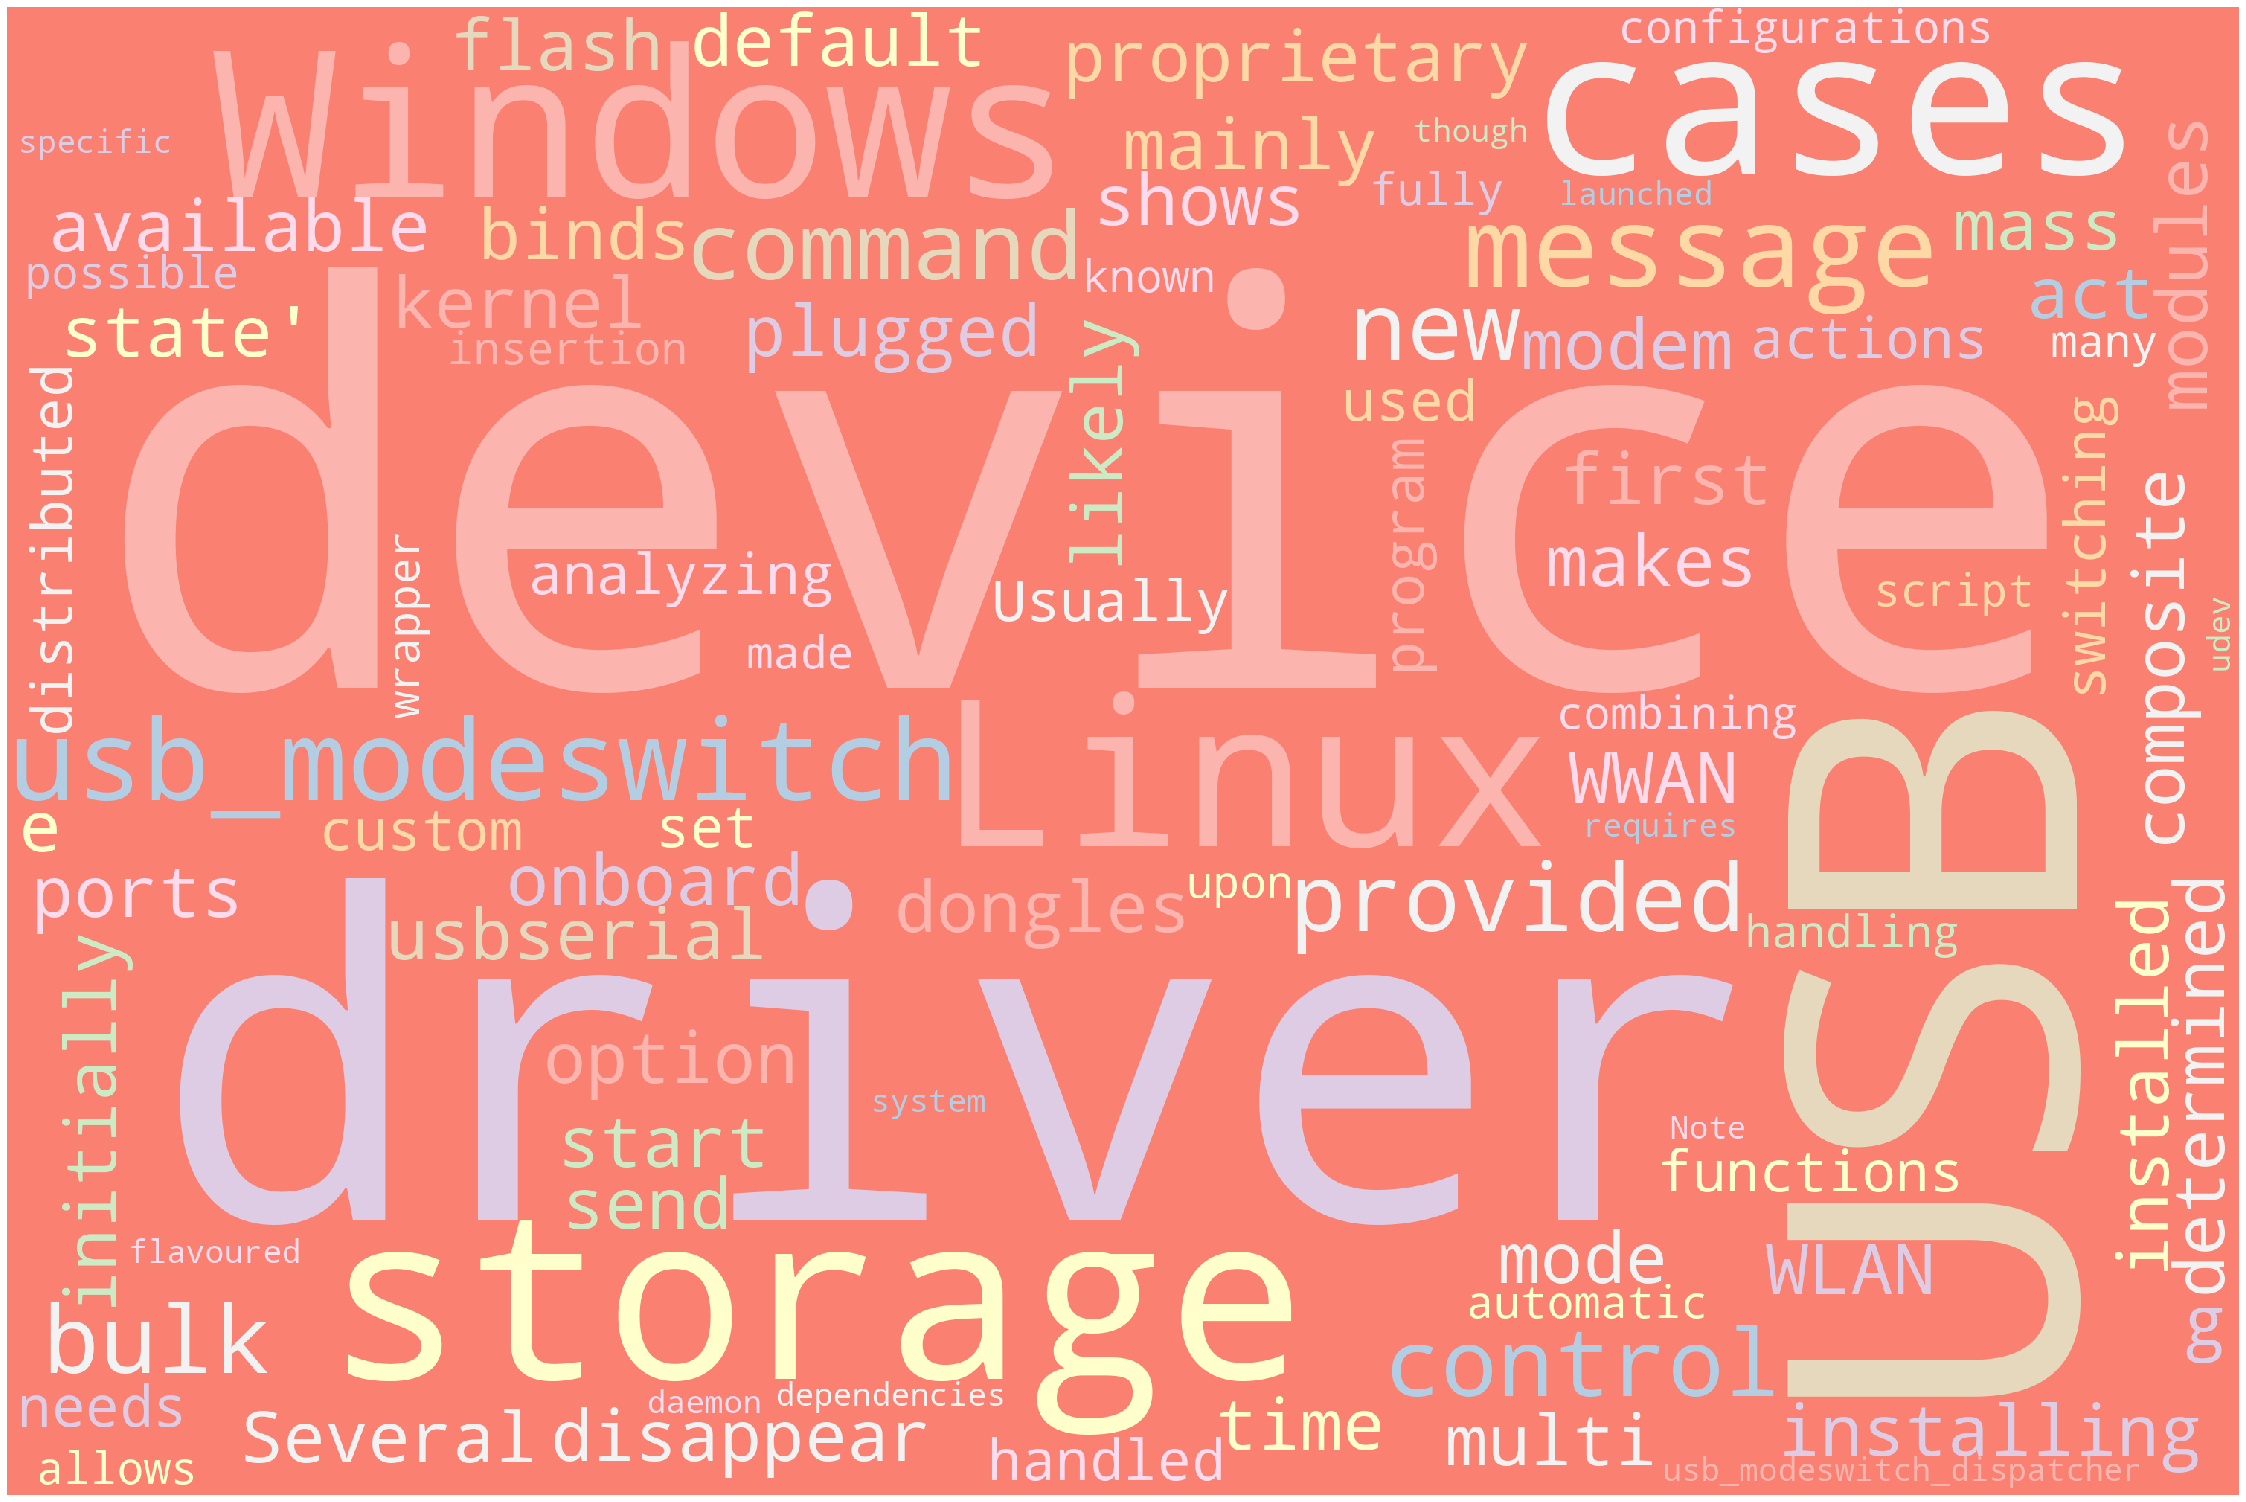

In [24]:
import json

from pathlib import Path

from wordcloud import WordCloud, STOPWORDS
from IPython.core.display import HTML
import matplotlib.pyplot as plt# Define a function to plot word cloud


def generate_word_cloud(text):
  # Generate word cloud
  wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(text)# Plot
  # Set figure size
  plt.figure(figsize=(40, 30))
  # Display image
  plt.imshow(wordcloud) 
  # No axis details
  plt.axis("off")
  # HTML(embed_code)



data = json.loads(Path("dennis.json").read_text())
manpages = [p["description"] for p in data]


index = 2

print(data[index]["command"])
generate_word_cloud(manpages[index])

In [47]:

import spacy
nlp=spacy.load('en_core_web_sm')

ner=nlp.get_pipe("ner")

TRAINING_DATA = [json.loads(f.read_text()) for f in Path('./data/json').iterdir() if f.is_file()]


# Add labels to the NER
for data in TRAINING_DATA:
  for ent in data["entities"]:
    print(ent)
    # ner.add_label(ent[1])


# # Disable pipeline components you dont need to change
# pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
# unaffected_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]


['Command', 0, 2]
['Command', 39, 41]
['Command', 58, 60]
['Command', 131, 133]
['Command', 277, 279]
['Command', 428, 430]
['Command', 582, 584]
['Command', 650, 652]
['Command', 729, 731]
['Command', 1891, 1893]
['Command', 1952, 1954]
['Command', 2120, 2122]
['Command', 2752, 2754]
['Command', 2782, 2784]
['Command', 3157, 3159]
['Command', 3180, 3182]
['Command', 4738, 4740]
['Command', 4768, 4770]
['Command', 4799, 4801]
['Command', 4822, 4824]
['Command', 4996, 4998]
['Command', 5011, 5013]
['Command', 5235, 5237]
['Command', 5242, 5244]
['Command', 5291, 5293]
['Command', 5362, 5364]
['Command', 5405, 5407]
['Command', 5410, 5412]
['Command', 5669, 5671]
['Command', 5835, 5837]
['Command', 5870, 5872]
['Command', 5966, 5968]
['Command', 6032, 6034]
['Command', 6040, 6042]
['Command', 6049, 6051]
['Command', 6128, 6130]
['Command', 6286, 6288]
['Compression', 389, 392]
['Compression', 473, 476]
['Compression', 479, 482]
['Compression', 630, 633]
['Compression', 371, 376]
['Compre

In [ ]:
# import nltk
# nltk.download('stopwords')

import string
import Levenshtein as lev
from nltk.corpus import stopwords


def clean_text(txt):
  txt = txt.lower()
  txt = txt.replace('\n', ' ').replace('\r', ' ').replace('\'', '')
  # Remove personal pronouns
  txt = txt.replace("\bI\b", "")
  # Remove punctuation
  txt = ''.join([c for c in txt if c not in string.punctuation])
  # Remove stopwords
  stoplist = list(stopwords.words('english'))
  txt = ' '.join([word for word in txt.split() if word not in stoplist])
  return txt

def similarity(question, description):
  distances = []
  parts = question.split(' ')
  for part in parts:
    for word in description.split(' '):
      distances.append(lev.distance(part, word))
  # return distances
  return sum(distances)
  # return lev.distance(question, description)


data = json.loads(Path("dennis.json").read_text())

question = clean_text("What command compresses a file?")


print(question)
possibilities = []
for cmd in data:
  command = cmd["command"]
  description = clean_text(cmd["description"])
  # print(similarity(question, description))
  if similarity(question, description) < 75:
    possibilities.append(command)

print(possibilities)



In [ ]:
from pathlib import Path
import gzip
import struct


class Man:
  def __init__(self, man_page):
    self.path    = Path(man_page).absolute()
    self.bytes   = self.path.read_bytes()

    self.is_gizp = self.bytes[0:2] == b'\x1f\x8b'
    if not self.is_gizp: raise IOError('Not a gzipped file')

    self.data = self.extract()
    self.groff()


  def extract(self):
    # method, flag, mtime = struct.unpack("<BBIxx", bytearray(self.bytes[2:10]))
    # if not flag & gzip.FNAME:
    #   filename = '.'.join(self.path.parts[-1].split('.')[0:-1])
    with gzip.open(self.path, 'rb') as f:
      return f.read().decode()


  def groff(self):
    data = []
    lines = self.data.split('\n')[1:]
    for line in lines:
      if line.startswith('.\\"'): continue
      print(line)
      # data.append(line)

    print("\n".join(self.data))



archive = Man("./chsh.1.gz")

print(archive)
print(archive.data)


# https://www.gnu.org/software/groff/groff-and-mom.pdf
